In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers, optimizers
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df=pd.read_csv('dataset/image/label_binary.csv',dtype=str)
df_test=pd.read_csv('dataset/test/label_test.csv',dtype=str)

In [3]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.20)

train_generator=datagen.flow_from_dataframe(
dataframe=df,
directory="dataset/image/",
x_col="file_name",
y_col="label",
subset="training",
batch_size=30,
seed=67,
shuffle=True,
#classes= ['No Tumor','Tumor'],
class_mode="categorical",
target_size=(256,256),
color_mode = "grayscale")

validation_generator=datagen.flow_from_dataframe(
dataframe=df,
directory="dataset/image/",
x_col="file_name",
y_col="label",
subset="validation",
batch_size=30,
seed=67,
shuffle=True,
class_mode="categorical",
#classes= ['No Tumor','Tumor'],
target_size=(256,256),
color_mode = "grayscale")

datagen=ImageDataGenerator(rescale=1./255.)

test=datagen.flow_from_dataframe(
dataframe=df_test,
directory="dataset/test/",
x_col="file_name",
y_col=None,
batch_size=30,
seed=67,
shuffle=False,
class_mode=None,
#classes= ['No Tumor','Tumor'],
target_size=(256,256),
color_mode = "grayscale" )

Found 2392 validated image filenames belonging to 2 classes.
Found 598 validated image filenames belonging to 2 classes.
Found 10 validated image filenames.


In [4]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(256,256,1)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 254, 254, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 127, 127, 64)      1

In [17]:
history = model.fit(
        x=train_generator,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=None,
        validation_freq=1,
        max_queue_size=10,
        workers=1,

)

model.save("dataset/model_try_binary.h5",overwrite=True,include_optimizer=True)  # always save your weights after training or during training


Epoch 1/10
80/80 [==============================] - 221s 3s/step - loss: 0.2500 - accuracy: 0.8913 - val_loss: 0.3759 - val_accuracy: 0.8846
Epoch 2/10
80/80 [==============================] - 210s 3s/step - loss: 0.2113 - accuracy: 0.9139 - val_loss: 0.1577 - val_accuracy: 0.9482
Epoch 3/10
80/80 [==============================] - 207s 3s/step - loss: 0.1706 - accuracy: 0.9335 - val_loss: 0.1722 - val_accuracy: 0.9431
Epoch 4/10
80/80 [==============================] - 209s 3s/step - loss: 0.1269 - accuracy: 0.9503 - val_loss: 0.1312 - val_accuracy: 0.9448
Epoch 5/10
80/80 [==============================] - 208s 3s/step - loss: 0.1132 - accuracy: 0.9624 - val_loss: 0.1550 - val_accuracy: 0.9465
Epoch 6/10
80/80 [==============================] - 207s 3s/step - loss: 0.0679 - accuracy: 0.9749 - val_loss: 0.1845 - val_accuracy: 0.9548
Epoch 7/10
80/80 [==============================] - 206s 3s/step - loss: 0.0696 - accuracy: 0.9753 - val_loss: 0.1467 - val_accuracy: 0.9548
Epoch 8/10
80

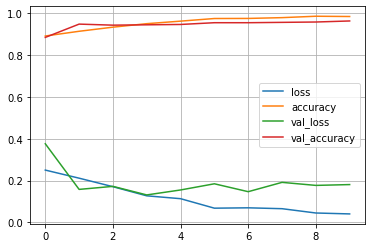

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot()
plt.grid()
plt.grid(which='minor')
plt.show()

In [19]:
model.evaluate(
    x=validation_generator,
    steps = 15
)

15/15 [==============================] - 36s 656ms/step - loss: 0.2138 - accuracy: 0.9578


[0.2137860804796219, 0.9577777981758118]

In [13]:
test_generator = test

#test_generator.reset()
pred=model.predict(test_generator,verbose=1)

print("predictions shape:", pred.shape)

predicted_class_indices=np.argmax(pred,axis=1)

1/1 [==============================] - 18s 18s/step
predictions shape: (10, 2)


In [14]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]


In [15]:

filenames=test_generator.filenames
filenames=filenames[:480]
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
#results.to_csv("results.csv",index=False)
print(filenames)
print(len(predictions))
print(results)

['IMAGE_2990.jpg', 'IMAGE_2991.jpg', 'IMAGE_2992.jpg', 'IMAGE_2993.jpg', 'IMAGE_2994.jpg', 'IMAGE_2995.jpg', 'IMAGE_2996.jpg', 'IMAGE_2997.jpg', 'IMAGE_2998.jpg', 'IMAGE_2999.jpg']
10
         Filename Predictions
0  IMAGE_2990.jpg       tumor
1  IMAGE_2991.jpg       tumor
2  IMAGE_2992.jpg       tumor
3  IMAGE_2993.jpg       tumor
4  IMAGE_2994.jpg       tumor
5  IMAGE_2995.jpg       tumor
6  IMAGE_2996.jpg       tumor
7  IMAGE_2997.jpg       tumor
8  IMAGE_2998.jpg       tumor
9  IMAGE_2999.jpg       tumor


In [14]:
IMAGE_2990.jpg	tumor
IMAGE_2991.jpg	tumor
IMAGE_2992.jpg	tumor
IMAGE_2993.jpg	tumor
IMAGE_2994.jpg	tumor
IMAGE_2995.jpg	no_tumor
IMAGE_2996.jpg	tumor
IMAGE_2997.jpg	tumor
IMAGE_2998.jpg	tumor
IMAGE_2999.jpg	tumor



SyntaxError: invalid syntax (<ipython-input-14-239ca439d2f1>, line 1)